# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## As a first step, let's import the necessary packages for this project

In [41]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

## Next, let's read the Image and print out some necessary stats so that we'll get the dimensions and then visualize (plot) the image.

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


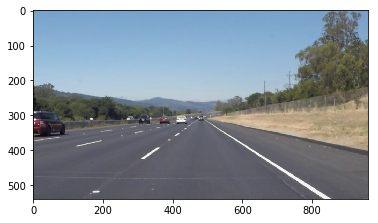

In [42]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

 Grab the x and y sizes and make two copies of the image
 With one copy we'll extract only the pixels that meet our selection,
 then we'll paint those pixels red in the original image to see our selection 
 overlaid on the original.

In [43]:
ysize = image.shape[0]
xsize = image.shape[1]
color_select= np.copy(image)
line_image = np.copy(image)

Color criteria is defined and the variables are modified to make the color selection

Next, what we need is the triangular kind shape. So now Let's let's get the region of interest.
Here, we introduce three new parameters which are left_bottom, right_bottom and an apex. So now, we'll modify these values according to our need to isolate the region.
Key Point: As per image processing, the origin (x=0, y=0) is in the upper left corner.

In [44]:
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])
        
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1])) 
    
color_select[color_thresholds] = [0,0,0]
line_image[~color_thresholds & region_thresholds] = [255,0,0]

Now let's Perform a linear fit which is y=Ax+B to each of the three sides of the triangle.
Key point: np.polyfit returns the coefficients [A, B] of the fit

In [ ]:
# Mask pixels below the threshold
# Find the region inside the lines
# Mask color selection
# Find where image is both colored right and in the region

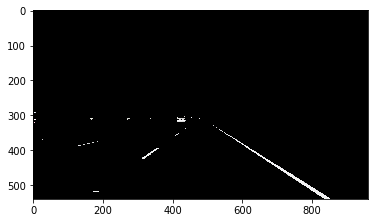

In [45]:
# Display our two output images
plt.imshow(color_select)

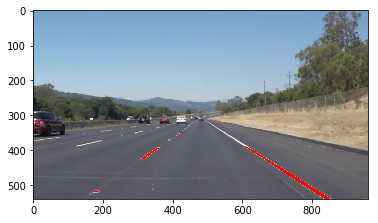

In [46]:
plt.imshow(line_image)

## And now Lane Detection Pipeline starts

First step, let's convert our original image into grayscale image. Module named OpenCV will be helpful to do this. And the converted image is shown below for better understanding.

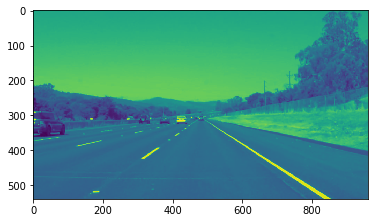

In [47]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray)

Second step in the pipeline is using Canny edge detection. Here I'm applying the canny function to the grayscale image. Low threshold and High threshold determines how strong the edges must be detected. Strength of the image is proportional to the pixel in the image. 
The algorithm will first detect strong edge (strong gradient) pixels above the high_threshold, and reject pixels below the low_threshold. Next, pixels with values between the low_threshold and high_threshold will be included as long as they are connected to strong edges. The output edges is a binary image with white pixels tracing out the detected edges and black everywhere else.

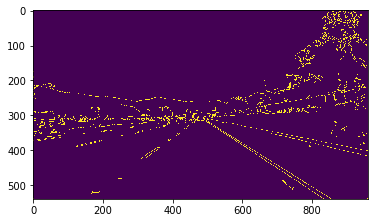

In [48]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(gray, low_threshold, high_threshold)
plt.imshow(edges)

Thirdly, let's apply Gaussian smoothing.Gaussian smoothing is a way of suppressing noise and spurious gradients by averaging. Kernel_size for Gaussian smoothing should be any odd number. A larger kernel_size implies averaging, or smoothing, over a larger area.

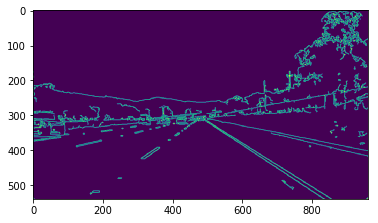

In [49]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(edges,(kernel_size, kernel_size), 0) 
plt.imshow(blur_gray)

In the fourth step, we have only dots in the image. Now let's make into line by connecting the dots. The Hough Transform is just the conversion from image space to Hough space.Example, dot in image space is line in hough space. If many line in the hough space intersect, we can conclude that we found the line. cv2.fillPoly() function is used to mask the quadrilateral region.

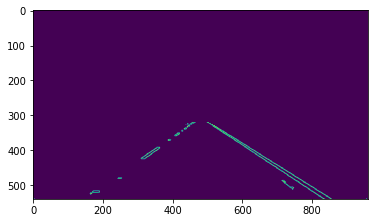

In [50]:
mask = np.zeros_like(blur_gray)   #rename img to edges

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
ignore_mask_color = 255

cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(blur_gray, mask)
plt.imshow(masked_edges)

Fifth step, As of now, we have a only the line. Now let's map out the full extent of the lane using average/extrapolate of the line segments. get_slope fuction helps in separating line segments by their slope. draw_lines function draws `lines` with `color` and `thickness`. Lines are drawn on the image inplace (mutates the image).

In [51]:
def get_slope(x1, y1, x2, y2):
    return ((y2 - y1) / (x2 - x1))

def draw_lines(img, lines, color=[255, 0, 0], thickness=16):

    top = 320 # approx field of vision of the camera. we can guess this is from ticks mark in above img.
    bottom = 540 # ysize of image
    
    left_x1s = []
    left_y1s = []
    left_x2s = []
    left_y2s = []
    right_x1s = []
    right_y1s = []
    right_x2s = []
    right_y2s = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Draw line segments in blue for error checking.
            cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], 6)
            
            slope = get_slope(x1, y1, x2, y2)
            
            if slope < 0:
                # eliminate bad lines
                if slope > -.5 or slope < -.8:
                    continue        
                left_x1s.append(x1)
                left_y1s.append(y1)
                left_x2s.append(x2)
                left_y2s.append(y2)
            else:
                # eliminate bad lines
                if slope < .5 or slope > .8:
                    continue        
                right_x1s.append(x1)
                right_y1s.append(y1)
                right_x2s.append(x2)
                right_y2s.append(y2)
                
    try:
        avg_right_x1 = int(np.mean(right_x1s))
        avg_right_y1 = int(np.mean(right_y1s))
        avg_right_x2 = int(np.mean(right_x2s))
        avg_right_y2 = int(np.mean(right_y2s))
        right_slope = get_slope(avg_right_x1, avg_right_y1, avg_right_x2, avg_right_y2)

        right_y1 = top
        right_x1 = int(avg_right_x1 + (right_y1 - avg_right_y1) / right_slope)
        right_y2 = bottom
        right_x2 = int(avg_right_x2 + (right_y2 - avg_right_y2) / right_slope)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except ValueError:
        pass

    try:
        avg_left_x1 = int(np.mean(left_x1s))
        avg_left_y1 = int(np.mean(left_y1s))
        avg_left_x2 = int(np.mean(left_x2s))
        avg_left_y2 = int(np.mean(left_y2s))
        left_slope = get_slope(avg_left_x1, avg_left_y1, avg_left_x2, avg_left_y2)

        left_y1 = top
        left_x1 = int(avg_left_x1 + (left_y1 - avg_left_y1) / left_slope)
        left_y2 = bottom
        left_x2 = int(avg_left_x2 + (left_y2 - avg_left_y2) / left_slope)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)        
    except ValueError:
        pass


Sixth step, Here rho is the distance resolution in pixels of the Hough grid, theta angular resolution in radians of the Hough grid , threshold is the minimum number of votes (intersections in Hough grid cell), min_line_length is the minimum number of pixels making up a line, max_line_gap is the maximum gap in pixels between connectable line segments.These values are adjusted in such a way that it constitutes a line.

The output from HoughLinesP will be lines, which is an array containing the endpoints (x1, y1, x2, y2) of all line segments detected by the transform operation. 


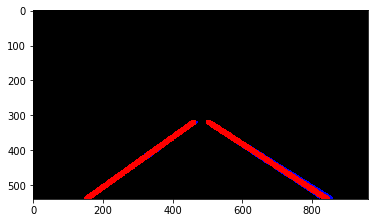

In [52]:
rho = 2 
theta = np.pi/180 
threshold = 15    
min_line_length = 40 
max_line_gap = 20    
line_image = np.copy(image)*0 


lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
draw_lines(line_img, lines)

plt.imshow(line_img)

Seventh step, we should combine the above image with our original image using cv2.addWeighted function. And the output is the combo image of the both.

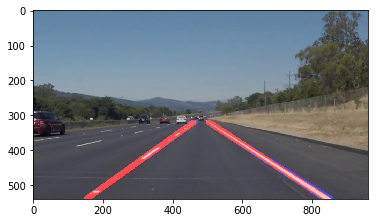

In [53]:
lines_edges = cv2.addWeighted(image, 0.8, line_img, 1, 0) 
plt.imshow(lines_edges)

## Series of Images

Here comes the pipeline implementation for Series of 5 original images. Whatever we did from the first step to fifth step, let's put all together in the same order and iterated it for all the 5 images one by one.

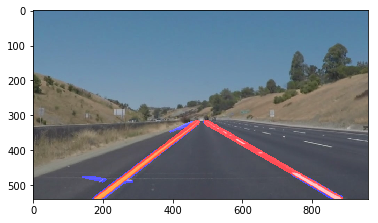

In [54]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    
    blur_gray = cv2.GaussianBlur(edges,(kernel_size, kernel_size), 0) 
    
    mask = np.zeros_like(blur_gray)  
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(blur_gray, mask)
    
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    
    line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    
    result = cv2.addWeighted(image, 0.8, line_img, 1, 0)
    
    return result

images = os.listdir("test_images/")
for img_file in images:
    #print(img_file)
    # Skip all files starting with line.
    if img_file[0:4] == 'line':
        continue
    
    image = mpimg.imread('test_images/' + img_file)   
    
    weighted = process_image(image)

    plt.imshow(weighted)
    #break
    mpimg.imsave('test_images/lines-' + img_file, weighted)

## Test on Videos

Videos are made up of series of images. Lets make two videos one with  continous white line on left side of the car and other with yellow line on the right side of the car and named the videos as
`solidWhiteRight.mp4`, 
`solidYellowLeft.mp4`

Now lets import the necessary packages to make the video and to view the video on the webpage. Module named VideoFileClip and HTML are used to do this.

In [55]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first.

In [56]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 50.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.89 s, sys: 988 ms, total: 4.88 s
Wall time: 4.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left.

In [58]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 50.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.6 s, sys: 2.4 s, total: 15 s
Wall time: 14 s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [59]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:14<00:00, 16.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14.1 s, sys: 1.42 s, total: 15.5 s
Wall time: 15.7 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))